In [3]:
# -*- coding: utf-8 -*-
from types import SimpleNamespace as Namespace
import pandas as pd
import glob
import numpy as np
import collections
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib
import matplotlib.style
matplotlib.style.use('ggplot')
import seaborn
import operator
import math
import seaborn as sns
import re
import json

In [4]:
# создаем метки класса
def AddLabel(data, count, n, df):
    # присваем метку
    cnt = count
    tmp = 0
    for i in range(0, len(data)):
        tmp = tmp + 1
        try:
            val = cnt + tmp
            df.loc[-1] = [data[i]['theme'], val]
            df.index = df.index + 1
            data[i].update({"label": val})
            AddLabel(data[i]['questions'], (val) * n, n * 10, df)
        except:
            val = cnt + tmp
            data[i].update({"label": val})
    return

In [5]:
# вытаскиваем метки для каждого объекта
def Unroll(data, labels, temp, n, m):
    for i in range(0, len(data)):
        try:
            while len(str(data[i]['label'])) <= len(str(temp[-1])):
                temp = temp[:-1]
            temp.append(data[i]['label'])
        except:
            temp.append(data[i]['label'])
        try:
            Unroll(data[i]['questions'], labels, temp, n, m)
            temp = temp[:-2]
        except:
            temp.append(data[i]['response'])
            labels.append(temp)
            temp = temp[:-2]

In [6]:
#формирование dataframe
def Create_Df(data, max_depth, df_chavo):
    cnt = 0
    for line in data:
        tmp_cnt = 0
        tmp = [] * 5
        for obj in line:
            if isinstance(obj, int) and tmp_cnt <= max_depth:
                tmp.append(obj)
                tmp_cnt = tmp_cnt + 1
            elif isinstance(obj, int) is False and tmp_cnt <= max_depth:
                while tmp_cnt <= max_depth:
                    tmp.append('None')
                    tmp_cnt = tmp_cnt + 1
                tmp.append(obj)
        df_chavo.loc[-1] = tmp
        df_chavo.index = df_chavo.index + 1
        cnt = cnt + 1
    return

In [17]:
def LoadTrain(data_csv):
    files = glob.glob("/home/varykha/Documents/diplom/td/classif/data/data*.csv")
    for file in files:
        tmp = pd.read_csv(file, sep=';')
        data_csv = pd.concat([tmp, data_csv], ignore_index=True)
    #tmp = pd.read_csv("/home/varykha/gpn_diplom/data1.csv", sep=';')
    data_csv = pd.concat([tmp, data_csv], ignore_index=True)
    data = FilterRowsOperator(data_csv)
    #data = FilterRowsQuestions(data_csv)
    #print(data)
    return data
    # data1 = data1[['Идентификатор обращения', 'Автор', 'Сообщения']]

In [19]:
#with answers
def LoadTrainAnswers(data_csv):
    files = glob.glob("/home/varykha/Documents/diplom/td/classif/data/data*.csv")
    for file in files:
        tmp = pd.read_csv(file, sep=';')
        data_csv = pd.concat([tmp, data_csv], ignore_index=True)
    #data = FilterRowsOperator(data_csv)
    #tmp = pd.read_csv("/home/varykha/gpn_diplom/data1.csv", sep=';')
    #data_ans = FilterRowsOperator(data_csv)
    data_csv = pd.concat([tmp, data_csv], ignore_index=True)
    data_quest = FilterRowsQuestions(data_csv)
    return data_quest

In [20]:
#выбираем ответы только оператора
def FilterRowsOperator(data_csv):
    data_csv = data_csv[['Идентификатор обращения', 'Автор', 'Сообщения']]
    data_csv.head()
    data_csv = data_csv[data_csv['Автор'].str.contains('Оператор*')==True]

    return data_csv

In [11]:
#выбираем ответы только оператора
def FilterRowsQuestions(data_csv):
    data_csv = data_csv[['Идентификатор обращения', 'Автор', 'Сообщения']]
    data_csv.head()
    data_csv = data_csv[data_csv['Автор'].str.contains('Оператор*')==False]
    return data_csv

In [12]:
def CousinDist(df_chavo, data_csv):
    count_vect = CountVectorizer()
    X_train_counts = count_vect.fit_transform(df_chavo['response'])
    print(X_train_counts.shape)
    tfidf_transformer = TfidfTransformer()
    X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
    print(X_train_tfidf.shape)

    #res = [0] * len(data_csv)
    #k = 0;
    #p = 0
    res=[]
    res2 = [0] * len(data_csv)

    for index, i in data_csv.iterrows():
        res.append([np.amax(cosine_similarity(count_vect.transform([data_csv['Сообщения'][index]]), X_train_tfidf)),
                    data_csv['Идентификатор обращения'][index],
                    df_chavo.iloc[np.argmax(cosine_similarity(count_vect.transform([data_csv['Сообщения'][index]]), X_train_tfidf))]['response'],
                    data_csv['Сообщения'][index]])
        '''if res[k] > 0:
            res2[p] = res[k]
            p = p + 1
        k = k + 1'''
    #print(np.amax(res))
    #print(np.amax(res2))

    d = pd.DataFrame(res, columns=['Косинусная мера','Идентификатор обращения','Сообщение ЧАВО', 'Сообщение'])
    return d
    #sns.kdeplot(s).figure.savefig('cos1.png')
    #s = pd.Series(res)
    #res_around = np.around(res, decimals=4)
    #dict_my = collections.Counter(res_around)
    #s = pd.Series(res)
    #s.plot.kde().figure.savefig('cos1.v1.png')
    #s.plot.hist(alpha=0.6).figure.savefig('histv.1.png')

    #s2 = pd.Series(res2)
    #res_around2 = np.around(res2, decimals=4)
    #dict_my2 = collections.Counter(res_around2d
    #s2 = pd.Series(res2)
    #s2.plot.kde().figure.savefig('cos1.v2.png')
    #s2.plot.hist(alpha=0.6).figure.savefig('histv.2.png')
    
    #d.plot.kde().figure.savefig('cos_v.png')
    #return d
                   


In [13]:
def ReturnLabel(df_chavo, theme_label, response):
    find = pd.DataFrame(df_chavo.loc[df_chavo['response'] == response])
    result = pd.DataFrame()
    result_list_theme = []
    result_list_label = []
    
    # print(find)
    merged_inner = pd.DataFrame(columns=['label', 'theme', 'response'])
    for i in range(0, 3):
        theme_i = 'theme' + str(i)
        left = pd.DataFrame(find[[theme_i, 'response']])
        left.rename(columns={theme_i: 'theme'}, inplace=True)
        # print(left)
        right = pd.DataFrame(theme_label[['label', 'theme']], columns=['label', 'theme'])
        temp = pd.merge(left, right, on='theme', how='inner')
        # print(result[result[['theme', 'label']]])        
        result = pd.concat([temp, result], ignore_index=True)
    for index, row in result.iterrows():
        result_list_theme.append( row['theme'])
        result_list_label.append(row['label'])
    result=pd.DataFrame(result_list_theme, columns=['label'])
    return(result.sort_index(ascending=False))

In [14]:
response = "Зайдите на сайт платежной системы «Мир» и выберите банк, в котором хотите получить карту. Со списком банков, выпускающих карту «Мир», можно ознакомиться на сайте privetmir.ru"
ReturnLabel(df_chavo, theme_label, response)


NameError: name 'df_chavo' is not defined

In [15]:
def ReturnQuestion(df_chavo, data_csv, num_response):
    find = pd.DataFrame(data_csv.loc[df_chavo['Идентификатор обращения'] == num_response])
    result = pd.DataFrame()
    # print(find)
    merged_inner = pd.DataFrame(columns=['label', 'theme', 'response'])
    for i in range(0, 4):
        theme_i = 'theme' + str(i)
        left = pd.DataFrame(find[[theme_i, 'response']])
        left.rename(columns={theme_i: 'theme'}, inplace=True)
        # print(left)
        right = pd.DataFrame(theme_label[['label', 'theme']], columns=['label', 'theme'])
        temp = pd.merge(left, right, on='theme', how='inner')
        # print(result[result[['theme', 'label']]])
        result = pd.concat([temp, result], ignore_index=True)
    print(result)


In [21]:
theme_label = pd.DataFrame(columns=['label', 'theme'])
# создадим числовые метки
f = open("chavo_cor.json", 'r', encoding="utf-8")
data = json.load(f)
AddLabel(data, 100, 10, theme_label)
theme_label = theme_label.drop_duplicates(subset='label', keep="last").sort_values(by='label').reset_index()
# не совсем корректный (not all labels)
# print(theme_label)
with open('chavo_cor_label.json', 'w', encoding="utf-8") as outfile:
    json.dump(data, outfile, ensure_ascii=False)

f1 = open("chavo_cor_label.json", 'r', encoding="utf-8")
data = json.load(f1)
labels = [] * 1000
Unroll(data, labels, [] * 6, 0, 0)

max_depth = 4

# формируем заголовки
column = []
for i in range(0, max_depth + 1):
    column.append('theme' + str(i))

column.append('response')
df_chavo = pd.DataFrame(columns=column)
Create_Df(labels, max_depth, df_chavo)

# print(df_chavo)
# считываем переписку
data_csv = pd.DataFrame()
data_csv = LoadTrain(data_csv)
data_csv = CousinDist(df_chavo, data_csv)

(244, 2496)
(244, 2496)


In [22]:
data_csv.head()

,Косинусная мера,Идентификатор обращения,Сообщение ЧАВО,Сообщение
0,0.000000,7f9306c1-854c-4ddf-94b4-13e913a565c8,"По техническим причинам, предложение тарифов с...",Здравствуйте!
1,0.375721,7f9306c1-854c-4ddf-94b4-13e913a565c8,В соответствии с условиями Программы лояльност...,Привязка двух бонусных карт к общему счету нев...
2,0.000000,00000000-0001-0000-0018-000110790854,"По техническим причинам, предложение тарифов с...",Здравствуйте!
3,0.535757,00000000-0001-0000-0018-000110790854,Вам необходимо открепить карту от своего номер...,"Вы можете сменить номер телефона, который прив..."
4,0.000000,00000000-0001-0000-0018-000110790892,"По техническим причинам, предложение тарифов с...",Здравствуйте!


In [23]:
data_csv_change = data_csv.loc[data_csv['Косинусная мера'] > 0.65]

In [24]:
#выбираем максимум косинусной меры в рамках ответа оператора
temp = data_csv_change.groupby(['Идентификатор обращения']).agg({'Косинусная мера': 'max'})
#убираем из основной выборки строки, которые не обаладают макс косинусной мерой
data_csv_cos_max = pd.merge(temp, data_csv_change, on=['Идентификатор обращения', 'Косинусная мера'], how='left')

In [25]:
data_csv_cos_max.head()

,Идентификатор обращения,Косинусная мера,Сообщение ЧАВО,Сообщение
0,00000000-0001-0000-0018-000109471528,0.650695,"Обновите, пожалуйста, приложение до последней ...","Пожалуйста, обновите приложение до последней в..."
1,00000000-0001-0000-0018-000109474719,0.779866,"Нет, таких АЗС нет.",Здравствуйте! Нет.
2,00000000-0001-0000-0018-000109478254,0.959845,Благодарим Вас за пользование приложением сети...,Благодарим Вас за пользование приложением сети...
3,00000000-0001-0000-0018-000109479360,0.660144,В соответствии с условиями Программы лояльност...,Спасибо за ожидание. Нет. Согласно правилам п...
4,00000000-0001-0000-0018-000109485010,0.727443,В соответствии с условиями Программы лояльност...,"\nСогласно правилам программы лояльности, к од..."


In [26]:
#вытаскиваем вопросы
data_ans = pd.DataFrame()
data_ans = LoadTrainAnswers(data_ans)
data_ans = data_ans.dropna()
data_ans = data_ans.reset_index()

In [27]:
data_ans.head()

,index,Идентификатор обращения,Автор,Сообщения
0,1,7f9306c1-854c-4ddf-94b4-13e913a565c8,Гость,Здравствуйте подскажите как объединить карты н...
1,5,00000000-0001-0000-0018-000110790854,Гость,"Доброй ночи, подскажите как отвязать старый но..."
2,9,00000000-0001-0000-0018-000110790892,7825682002963869,Доброй ночи
3,10,00000000-0001-0000-0018-000110790892,7825682002963869,Ау
4,14,00000000-0001-0000-0018-000110790908,Гость,"Здравствуйте, подскажите почему статус карты н..."


In [28]:
#берем последнее сообщение обращения
temp_ans = data_ans.groupby(['Идентификатор обращения']).agg({'index': 'max'})
data_csv_last_ans = pd.merge(temp_ans, data_ans, on=['index'], how='left')

In [29]:
#берем все сообщение обращения и склеиваем их
data_csv_all_ans = data_ans.groupby('Идентификатор обращения')['Сообщения'].apply(','.join).reset_index()

In [30]:
data_csv_last_ans.tail()

,index,Идентификатор обращения,Автор,Сообщения
152962,888552,ffd7fa59-0f2d-4c20-a45f-48c97ad19456,Кристина Гришина,добрый день.нет доступа к телефону привязаному...
152963,431244,ffe0c965-2677-4de4-9caf-1d715492fbae,Анастасия Сорокина,"добрый день! прошу изменить номер телефона, п..."
152964,969838,ffeb7328-90bc-4565-8201-bcd2086ca42f,Дмитрий Корнеев,ясно спасибо.
152965,246968,fff01dfa-75c8-44a5-9253-a15f7717da1d,Subscriber,с ебанутыми диалоги нет смысла вести
152966,442091,fff0f7d4-e234-4000-8c5f-4d22e00c32ae,Дмитрий,спасибо


In [39]:
temp_ans.head()

,index
Идентификатор обращения,
00000000-0001-0000-0018-000109468187,1066199
00000000-0001-0000-0018-000109468323,1066203
00000000-0001-0000-0018-000109468594,1066221
00000000-0001-0000-0018-000109468623,1066224
00000000-0001-0000-0018-000109468751,1066228


In [31]:
final = pd.merge(data_csv_last_ans, data_csv_cos_max, on=['Идентификатор обращения'], how='inner')

In [32]:
final.head()

,index,Идентификатор обращения,Автор,Сообщения,Косинусная мера,Сообщение ЧАВО,Сообщение
0,1066409,00000000-0001-0000-0018-000109471528,Guest,"здравствуйте, в приложении не сохраняется мой ...",0.650695,"Обновите, пожалуйста, приложение до последней ...","Пожалуйста, обновите приложение до последней в..."
1,1066912,00000000-0001-0000-0018-000109474719,Гость,"Добрый день, вы снова повысили лимит для перех...",0.779866,"Нет, таких АЗС нет.",Здравствуйте! Нет.
2,1067355,00000000-0001-0000-0018-000109478254,Гость,Раньше сразу было указано сколько осталось лит...,0.959845,Благодарим Вас за пользование приложением сети...,Благодарим Вас за пользование приложением сети...
3,1067572,00000000-0001-0000-0018-000109479360,7825682054563260,"Здравствуйте, хочу активировать ещё одну карту...",0.660144,В соответствии с условиями Программы лояльност...,Спасибо за ожидание. Нет. Согласно правилам п...
4,1068091,00000000-0001-0000-0018-000109485010,Гость,Не могу объединить карту и аннулировать старую,0.727443,В соответствии с условиями Программы лояльност...,"\nСогласно правилам программы лояльности, к од..."


In [33]:
#добавляем метки (ТУТ ПЕРЕДЕЛАНО НА ЧИСЛОВЫЕ, В ОРИГИНАЛЕ - ТЕКСТ) согласно ответу из ЧАВО (метки будут у сообщений из переписки)
for i in range(0,2):
    final['theme'+ str(i)]='None'
    
for index, row in final.iterrows():
    #print(index)
    response = row['Сообщение ЧАВО']    
    #print(response)    
    res_lab = pd.DataFrame(ReturnLabel(df_chavo, theme_label, str(response)))
    for i in range(0,res_lab.shape[0]):
        #print(i, res_lab.iloc[i]['label'])
        final.at[index, 'theme'+ str(i)] = res_lab.iloc[i]['label']
        #print(row['theme'+ str(i)])

In [34]:
final = pd.merge(final, data_csv_all_ans, on=['Идентификатор обращения'], how='inner')

In [35]:
final.columns = ['index', 'Идентификатор обращения', 'Автор', 'Обращение последнее', 'Косинусная мера','Сообщение ЧАВО', 'Сообщение', 'theme0', 'theme1', 
            'theme2', 'theme3', 'Обращение полное']

In [36]:
final.head(30)

,index,Идентификатор обращения,Автор,Обращение последнее,Косинусная мера,Сообщение ЧАВО,Сообщение,theme0,theme1,theme2,theme3,Обращение полное
0,1066409,00000000-0001-0000-0018-000109471528,Guest,"здравствуйте, в приложении не сохраняется мой ...",0.650695,"Обновите, пожалуйста, приложение до последней ...","Пожалуйста, обновите приложение до последней в...",105,1053,NaN,NaN,"здравствуйте, в приложении не сохраняется мой ..."
1,1066912,00000000-0001-0000-0018-000109474719,Гость,"Добрый день, вы снова повысили лимит для перех...",0.779866,"Нет, таких АЗС нет.",Здравствуйте! Нет.,102,None,NaN,NaN,"Добрый день, вы снова повысили лимит для перех..."
2,1067355,00000000-0001-0000-0018-000109478254,Гость,Раньше сразу было указано сколько осталось лит...,0.959845,Благодарим Вас за пользование приложением сети...,Благодарим Вас за пользование приложением сети...,101,1011,101108.0,NaN,"Обратная связь по обновленном приложению ,Рань..."
3,1067572,00000000-0001-0000-0018-000109479360,7825682054563260,"Здравствуйте, хочу активировать ещё одну карту...",0.660144,В соответствии с условиями Программы лояльност...,Спасибо за ожидание. Нет. Согласно правилам п...,101,1012,NaN,NaN,"Здравствуйте, хочу активировать ещё одну карту..."
4,1068091,00000000-0001-0000-0018-000109485010,Гость,Не могу объединить карту и аннулировать старую,0.727443,В соответствии с условиями Программы лояльност...,"\nСогласно правилам программы лояльности, к од...",101,1012,NaN,NaN,"Сколько карт можно добавить в приложение?,При..."
5,1069014,00000000-0001-0000-0018-000109491967,Гость,"Вечер добрый\nНахожусь на АЗС 201,пытался запр...",0.820871,Мобильное приложение работает по системе «пред...,Мобильное приложение работает по системе «пред...,105,1051,NaN,NaN,"Вечер добрый\nНахожусь на АЗС 201,пытался запр..."
6,1069342,00000000-0001-0000-0018-000109494722,Гость,"Скажите пожайлуста, а на автоматической Азс 22...",0.724484,"Все АЗС сети «Газпромнефть», расположенные на ...",Да.В акции участвуют все АЗС сети «Газпромнефт...,106,None,NaN,NaN,"Скажите пожайлуста, а на автоматической Азс 22..."
7,1070112,00000000-0001-0000-0018-000109503982,Гость,Приветствую.\nЗачем ваши разработчики сделали ...,0.959845,Благодарим Вас за пользование приложением сети...,Благодарим Вас за пользование приложением сети...,101,1011,101108.0,NaN,Приветствую.\nЗачем ваши разработчики сделали ...
8,1070371,00000000-0001-0000-0018-000109505729,7825682039736783,Испортились совсем,0.940704,Разница в стоимости топлива в разных регионах ...,Разница в стоимости топлива в разных регионах ...,109,None,NaN,NaN,"Доброе утро,У вас была акция скидка один рубль..."
9,1071001,00000000-0001-0000-0018-000109508511,7825 6820 4205 5783,+79213235502\nЮрий Николаевич\nСанкт-Петербург,0.831111,Благодарим Вас за пользование приложением сети...,Спасибо за ожидание. По Вашему вопросу сформир...,101,1011,101108.0,NaN,Так я не хочу привязыааться к номеру телефона....


## Классификатор

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import sklearn

In [50]:
#SVC after grid_search (final)
X = final_filter['Обращение полное']
Y = final_filter['theme0'].astype('int')

X_train, X_test, y_train, y_test = train_test_split(final_filter['Обращение полное'], final_filter['theme0'].astype('int'), test_size = 0.3, random_state=241)
vectorizer_n = TfidfVectorizer()

count_vect = CountVectorizer()
X_train = count_vect.fit_transform(X_train)

clf_svc = SVC(gamma='scale', decision_function_shape='ovr', C = 100, random_state=241, kernel='rbf')
clf_svc.fit(X_train, y_train)

SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=241, shrinking=True, tol=0.001,
    verbose=False)

In [102]:
X = final['Обращение полное']
Y = final['theme0'].astype('int')

In [103]:
X_train, X_test, y_train, y_test = train_test_split(final_filter['Обращение полное'], final_filter['theme0'].astype('int'), test_size = 0.3, random_state=241)

In [104]:
count_vect = CountVectorizer()
X_train = count_vect.fit_transform(X_train)

In [109]:
#SVC
clf_svc = SVC()
grid_svc = {'C':[1,10,100,1000],'gamma':[1,0.1,0.001,0.0001], 'kernel':['linear','rbf']}
kf_svc = sklearn.model_selection.KFold(shuffle=True, random_state=1, n_splits=5)
gs_svc = GridSearchCV(clf_svc, grid_svc, scoring='accuracy')
gs_svc.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.001, 0.0001],
                         'kernel': ['linear', 'rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [114]:
print('best score: ', gs_svc.best_score_)
print('best estimatorr: ', gs_svc.best_estimator_)

best score:  0.8603072787241965
best estimatorr:  SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


In [123]:
#SVC
clf_svc2 = SVC()
grid_svc2 = {'gamma':[1, 0.1, 0.001,0.0001]}
kf_svc2 = sklearn.model_selection.KFold(shuffle=True, random_state=1, n_splits=5)
gs_svc2 = GridSearchCV(clf_svc2, grid_svc2, scoring='accuracy')
gs_svc2.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'gamma': [1, 0.1, 0.001, 0.0001]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [ ]:
#SVC after grid_search
X = final_filter['Обращение полное']
Y = final_filter['theme0'].astype('int')

count_vect = CountVectorizer()
X = count_vect.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(final_filter['Обращение полное'], final_filter['theme0'].astype('int'), test_size = 0.3, random_state=241)
vectorizer_n = TfidfVectorizer()


clf_svc = SVC(gamma='scale', decision_function_shape='ovo', C = 100, random_state=241, kernel='rbf', gamma=0.001)
clf_svc.fit(X_train, Y_train)

In [111]:
#SVC
clf_svc1 = SVC()
grid_svc1 = {'C':[1,10,100,1000],'gamma':[1,0.1,0.001,0.0001], 'kernel':['linear','rbf']}
kf_svc = sklearn.model_selection.KFold(shuffle=True, random_state=1, n_splits=5)
gs_svc1 = GridSearchCV(clf_svc1, grid_svc1, scoring='accuracy', cv=kf_svc)
gs_svc1.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.001, 0.0001],
                         'kernel': ['linear', 'rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [113]:
print('best score: ', gs_svc1.best_score_)
print('best estimatorr: ', gs_svc1.best_estimator_)

best score:  0.8611767675071951
best estimatorr:  SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


In [122]:
gs_svc1.cv_results_

{'mean_fit_time': array([10.04642391, 37.96856103, 10.02138853, 26.84601579,  9.99595447,
        13.73545647, 10.00087504, 16.20671711, 13.16443052, 59.12190976,
        13.17318645, 34.13900146, 13.15177064, 10.51723657, 13.14529686,
        13.51512475, 27.14576626, 59.01909795, 27.12119541, 34.04445033,
        27.14679947,  9.2675787 , 27.35345922, 10.4171658 , 59.61847625,
        59.21045976, 59.61230431, 34.1238987 , 59.62206655,  9.79539866,
        59.6734375 ,  9.47430634]),
 'std_fit_time': array([ 0.19892989,  0.37662213,  0.16706424,  0.24137394,  0.18737729,
         0.03255991,  0.17629283,  0.01991207,  0.67892739,  2.64714376,
         0.67191766,  0.8574655 ,  0.7116518 ,  0.06080222,  0.66786628,
         0.05279892,  4.50143324,  2.48695572,  4.49529086,  0.45809202,
         4.51195763,  0.05728085,  4.31787618,  0.05357102, 11.25936905,
         2.38678683, 11.2643278 ,  0.43166242, 11.24908288,  0.10704079,
        11.29053206,  0.07984269]),
 'mean_score_time':

In [125]:

import matplotlib.pyplot as plt

In [120]:
def show_param_grid(optimizer, param_grid, p_name):
    cv_results = optimizer.cv_results_       
    plt.plot(param_grid[p_name], cv_results['mean_test_score'])
    plt.xlabel(p_name)
    plt.ylabel('mean_test_score')
    plt.show()
    return optimizer

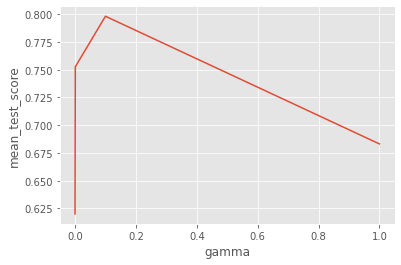

In [124]:
show_param_grid(gs_svc2, grid_svc2, 'gamma');

In [34]:
#1
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(X)
clf_svc = SVC(gamma='scale', decision_function_shape='ovo', C = 1.0, random_state=241)
clf_svc.fit(X, Y)

KeyboardInterrupt: 

In [248]:
#2
X_n = final_filter['Обращение полное']
Y_n = final_filter['theme0'].astype('int')
vectorizer_n = TfidfVectorizer()
X_n = vectorizer_n.fit_transform(X_n)
clf_svc = SVC(gamma='scale', decision_function_shape='ovo', C = 1.0, random_state=241)
clf_svc.fit(X_n, Y_n)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovo', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=241, shrinking=True, tol=0.001,
    verbose=False)

In [228]:
str_r = 'ТЕХНИЧЕСКИЙ СБОЙ ПРИ РАБОТЕ ПРИЛОЖЕНИЯ AZS GO'
str_r = vectorizer_n.transform([str_r])
clf_svc.predict(str_r)

array([105])

In [229]:
pred = clf_svc.predict(str_r)

In [230]:
pred

array([105])

In [76]:
final['theme0'].head()

0    105
1    102
2    101
3    101
4    101
Name: theme0, dtype: object

In [35]:
from sklearn.model_selection import train_test_split

In [98]:
X_train, X_test, y_train, y_test = train_test_split(final_filter['Обращение полное'], final_filter['theme0'].astype('int'), test_size = 0.3, random_state=241)

In [126]:
[final_filter['Обращение полное']]

[0        здравствуйте, в приложении не сохраняется мой ...
 1        Добрый день, вы снова повысили лимит для перех...
 2        Обратная связь по обновленном приложению ,Рань...
 3        Здравствуйте, хочу активировать ещё одну карту...
 4        Сколько карт можно добавить  в приложение?,При...
                                ...                        
 16796    Здравствуйте, как можно поменять номер телефон...
 16797    а подскажите как привязать новую карту к тому ...
 16798    добрый день. по моему обращению была создана з...
 16799    Со своего телефона не получилось  актевировать...
 16800    Хотела узнать, обращение дошло и как долго буд...
 Name: Обращение полное, Length: 16445, dtype: object]

In [100]:
X_train 

3935     Здравствуйте! Оптимизируйте пожалуйста приложе...
9317     Почему не войти в приложение?,7825682033874788...
11866    как удалить другую карту изприложения,и добави...
2727     ?,а если заплачу больше чем запавлюсь, деньги ...
3279     Добрый день. Подскажите, моя карта зарегистрир...
                               ...                        
8803     АЗС 20 на ул. Владимировская в Новосибирске уж...
8829     Как начисляется кэшбэк по карте Почта банка?,У...
152      доброго вечера, у меня сменился телефон, к кот...
11184                 А нельзя сделать виртуальную карту? 
12940    Добрый день. Я заправлялась 12.06.2019 30 литр...
Name: Обращение полное, Length: 11511, dtype: object

In [101]:
Y_train

<4201x24003 sparse matrix of type '<class 'numpy.float64'>'
	with 80446 stored elements in Compressed Sparse Row format>

In [91]:
count_vect11 = CountVectorizer()
X_train = count_vect11.fit_transform(X_train)

In [58]:
#3
clf_svc1 = SVC(gamma='scale', decision_function_shape='ovo', C = 1.0, random_state=241)
clf_svc1.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovo', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=241, shrinking=True, tol=0.001,
    verbose=False)

In [59]:
X_test = count_vect11.transform(X_test)
pred = clf_svc1.predict(X_test)

AttributeError: lower not found

In [94]:
from sklearn.metrics import accuracy_score

In [56]:
accuracy_score(y_test, pred)

NameError: name 'pred' is not defined

In [92]:
#4
clf_svc2 = SVC(kernel='linear', C = 1.0, random_state=241)
clf_svc2.fit(X_train, y_train)
X_test = count_vect11.transform(X_test)
pred1 = clf_svc2.predict(X_test)

In [95]:
accuracy_score(y_test, pred1)

0.8558978516416701

## Фильтрация нужных (популярных тем)  и запись в файл

In [41]:
final = final.drop('theme3',1 )
final = final.drop('index', 1)

In [42]:
final['theme2'].unique()

array([    nan, 101108., 101103., 101102.,   1052., 101105., 105125.,
       101107., 101106., 101104.,   1053., 101101.])

In [43]:
final['theme1'].unique()

array([1053, 'None', 1011, 1012, 1051, 1052, 1054, 1013, 101, 1040, 109,
       1014, 1073], dtype=object)

есть глупость с темами 105 и 101 - они повторяются, в результате чего 101 записыавется в theme1

In [44]:
final1 = final.loc[final['theme1'] != 109]
final1 = final.loc[final['theme1'] != 101]

In [45]:
#выбираем только популярные 
final_filter = final1.loc[(final1['theme0'] == 101) | (final1['theme0'] == 102) |(final1['theme0'] == 105)]
final_filter = final_filter.loc[final_filter['theme1'] != 109]
final_filter = final_filter.loc[final_filter['theme1'] != 101]

In [46]:
final_filter.head()

,Идентификатор обращения,Автор,Обращение последнее,Косинусная мера,Сообщение ЧАВО,Сообщение,theme0,theme1,theme2,Обращение полное
0,00000000-0001-0000-0018-000109471528,Guest,"здравствуйте, в приложении не сохраняется мой ...",0.650695,"Обновите, пожалуйста, приложение до последней ...","Пожалуйста, обновите приложение до последней в...",105,1053,NaN,"здравствуйте, в приложении не сохраняется мой ..."
1,00000000-0001-0000-0018-000109474719,Гость,"Добрый день, вы снова повысили лимит для перех...",0.779866,"Нет, таких АЗС нет.",Здравствуйте! Нет.,102,None,NaN,"Добрый день, вы снова повысили лимит для перех..."
2,00000000-0001-0000-0018-000109478254,Гость,Раньше сразу было указано сколько осталось лит...,0.959845,Благодарим Вас за пользование приложением сети...,Благодарим Вас за пользование приложением сети...,101,1011,101108.0,"Обратная связь по обновленном приложению ,Рань..."
3,00000000-0001-0000-0018-000109479360,7825682054563260,"Здравствуйте, хочу активировать ещё одну карту...",0.660144,В соответствии с условиями Программы лояльност...,Спасибо за ожидание. Нет. Согласно правилам п...,101,1012,NaN,"Здравствуйте, хочу активировать ещё одну карту..."
4,00000000-0001-0000-0018-000109485010,Гость,Не могу объединить карту и аннулировать старую,0.727443,В соответствии с условиями Программы лояльност...,"\nСогласно правилам программы лояльности, к од...",101,1012,NaN,"Сколько карт можно добавить в приложение?,При..."


In [74]:
final_filter = final_filter[['Косинусная мера','Сообщение ЧАВО', 'Сообщение', 'theme0', 'theme1', 'theme2','Обращение полное', 'Обращение последнее']]

In [75]:
dict_to_json = {}
dict_to_json_filter = {}

In [76]:
for t1 in final1['theme0'].unique():
    for t2 in final1['theme1'].unique():
        try:
            #print(final.loc[final['theme1'] == t2])
            try:
                for t3 in final1['theme2'].unique():
                    dict_tmp = {}
                    dict_tmp[t3] = final1.loc[final1['theme2'] == t3]
                    dict_to_json[t1][t2] = dict_tmp
                    s=0
            except:
                dict_tmp = {}
                dict_tmp[t2] = final1.loc[final1['theme1'] == t2]
                dict_to_json[t1] = dict_tmp
        except:
            dict_to_json[t1] = final1.loc[final1['theme0'] == t1]

In [77]:
for t1 in final_filter['theme0'].unique():
    for t2 in final_filter['theme1'].unique():
        try:
            #print(final_filter.loc[final_filter['theme1'] == t2])
            try:
                for t3 in final_filter['theme2'].unique():
                    dict_tmp = {}
                    dict_tmp[str(t3)] =  final_filter.loc[final_filter['theme2']==t3].to_json(orient='records')
                    #dict_tmp = {dict_tmp[str(t3)]:[{'Сообщение':final_filter.loc[final_filter['theme2'] == t3]['Сообщение']}]}
                    print(dict_tmp)
                    #dict_tmp[str(t3)] = final_filter.loc[final_filter['theme2'] == t3]
                    dict_to_json_filter[str(t1)][str(t2)] = dict_tmp
                    s=0
            except:
                dict_tmp = {}
                dict_tmp[str(t2)] =  final_filter.loc[final_filter['theme1']==t2].to_json(orient='records')
                    
                #dict_tmp[str(t2)] = final_filter.loc[final_filter['theme1'] == t2]
                dict_to_json_filter[str(t1)] = dict_tmp
        except:            
            dict_to_json_filter[str(t1)] = final_filter.loc[final_filter['theme0'] == t1].to_json(orient='records')        
            #dict_to_json_filter[str(t1)] = final_filter.loc[final_filter['theme0'] == t1]

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [78]:
dict_to_json

{105: {1053:          index               Идентификатор обращения             Автор  \
  0      1066409  00000000-0001-0000-0018-000109471528             Guest   
  9919    780247  00000000-0001-0000-0018-000112201926  7825682056571915   
  9924    780679  00000000-0001-0000-0018-000112203235             Guest   
  10050   789123  00000000-0001-0000-0018-000112237543             Guest   
  10120   794006  00000000-0001-0000-0018-000112254355             Guest   
  ...        ...                                   ...               ...   
  16599   519020  935aba33-175d-44eb-9cea-454a50ac335b            Натали   
  16618   897065  9c906409-172f-4fc4-893d-8772d27650ef          Анатолий   
  16631  1018637  a0aeef6a-3b55-4b88-a127-c9dd8e870304              Илья   
  16666   934701  b391ccf6-5ab0-47a0-ba18-2a49561b4644           Валерий   
  16798  1030535  fe66972b-8b82-41d5-a680-369a248509ea           Aleksey   
  
                                       Обращение последнее  Косинусная мер

In [159]:
dict_to_json_filter

{'105': {'1053':        Косинусная мера                                     Сообщение ЧАВО  \
  0             0.650695  Обновите, пожалуйста, приложение до последней ...   
  9919          0.678954  Да, покупки топлива, совершенные с помощью при...   
  9924          0.889624  Вы может уточнить свой бонусный баланс в профи...   
  10050         0.759207  Да, покупки топлива, совершенные с помощью при...   
  10120         0.933133  Да, покупки топлива, совершенные с помощью при...   
  10121         0.933133  Да, покупки топлива, совершенные с помощью при...   
  10141         0.954077  Вы может уточнить свой бонусный баланс в профи...   
  10179         0.954077  Вы может уточнить свой бонусный баланс в профи...   
  10223         0.909693  Вы может уточнить свой бонусный баланс в профи...   
  10238         0.885248  Да, покупки топлива, совершенные с помощью при...   
  10240         0.825498  Да, покупки топлива, совершенные с помощью при...   
  10264         0.954077  Вы может ут

In [272]:
with open("json_for_classif", "w", encoding="utf-8", ) as file:
    json.dump(dict_to_json_filter, file, indent = 4, en)

In [ ]:
response = "Список актуальных акций Вы можете посмотреть, нажав значок «Акции» внизу экрана."
ReturnLabel(df_chavo, theme_label, response)

In [ ]:
d = pd.DataFrame(CousinDist(df_chavo, data_csv))

In [ ]:
d = d.loc[d['Косинусная мера'] > 0.65]

In [ ]:
d.describe()

In [14]:
d.head()

,Косинусная мера,Идентификатор обращения,Сообщение ЧАВО,Сообщение
37,0.947522,00000000-0001-0000-0018-000110791454,Зайдите на сайт платежной системы «Мир» и выбе...,Зайдите на сайт платежной системы «Мир» и выбе...
56,0.913839,00000000-0001-0000-0018-000110791653,"Остаток денежных средств, зарезервированных пр...","Остаток денежных средств, зарезервированных пр..."
63,0.959393,00000000-0001-0000-0018-000110791952,Мобильное приложение работает по системе «пред...,Мобильное приложение работает по системе «пред...
83,0.785855,00000000-0001-0000-0018-000110792791,Установить мобильное приложение «Газпромнефть»...,КАК ПОУЧАСТВОВАТЬ В АКЦИИ?\n1.\tУстановить при...
163,0.955121,00000000-0001-0000-0018-000110794430,Привязка банковской карты в профиле: - на кар...,Привязка банковской карты в профиле: \n- на ка...


In [15]:
df_chavo = df_chavo[['theme0', 'theme1', 'theme2', 'response']]

In [16]:
df_chavo.shape

(244, 4)

In [195]:
response = "Зайдите на сайт платежной системы «Мир» и выберите банк, в котором хотите получить карту. Со списком банков, выпускающих карту «Мир», можно ознакомиться на сайте privetmir.ru"
ReturnLabel(df_chavo, theme_label, response)


TypeError: append() takes exactly one argument (2 given)

In [21]:
d.head()

,Косинусная мера,Идентификатор обращения,Сообщение ЧАВО,Сообщение,theme0,theme1,theme2
37,0.947522,00000000-0001-0000-0018-000110791454,Зайдите на сайт платежной системы «Мир» и выбе...,Зайдите на сайт платежной системы «Мир» и выбе...,None,None,None
56,0.913839,00000000-0001-0000-0018-000110791653,"Остаток денежных средств, зарезервированных пр...","Остаток денежных средств, зарезервированных пр...",None,None,None
63,0.959393,00000000-0001-0000-0018-000110791952,Мобильное приложение работает по системе «пред...,Мобильное приложение работает по системе «пред...,None,None,None
83,0.785855,00000000-0001-0000-0018-000110792791,Установить мобильное приложение «Газпромнефть»...,КАК ПОУЧАСТВОВАТЬ В АКЦИИ?\n1.\tУстановить при...,None,None,None
163,0.955121,00000000-0001-0000-0018-000110794430,Привязка банковской карты в профиле: - на кар...,Привязка банковской карты в профиле: \n- на ка...,None,None,None


In [37]:
#добавляем метки согласно ответу из ЧАВО (метки будут у сообщений из переписки)
for i in range(0,2):
    d['theme'+ str(i)]='None'
    
for index, row in d.iterrows():
    #print(index)
    response = row['Сообщение ЧАВО']    
    #print(response)    
    res_lab = pd.DataFrame(ReturnLabel(df_chavo, theme_label, str(response)))
    for i in range(0,res_lab.shape[0]):
        #print(i, res_lab.iloc[i]['label'])
        d.at[index, 'theme'+ str(i)] = res_lab.iloc[i]['label']
        #print(row['theme'+ str(i)])

In [ ]:
d_chavo_shot.to_csv('result_with_labels', sep=';')

In [40]:
d.head()

,Косинусная мера,Идентификатор обращения,Сообщение ЧАВО,Сообщение,theme0,theme1,theme2
37,0.947522,00000000-0001-0000-0018-000110791454,Зайдите на сайт платежной системы «Мир» и выбе...,Зайдите на сайт платежной системы «Мир» и выбе...,ПРИЛОЖЕНИЕ АЗС GO,СОВМЕСТНАЯ АКЦИЯ МИР - АЗС.GO,NaN
56,0.913839,00000000-0001-0000-0018-000110791653,"Остаток денежных средств, зарезервированных пр...","Остаток денежных средств, зарезервированных пр...",МОБИЛЬНОЕ ПРИЛОЖЕНИЕ,ОПЛАТА ЧЕРЕЗ МП,NaN
63,0.959393,00000000-0001-0000-0018-000110791952,Мобильное приложение работает по системе «пред...,Мобильное приложение работает по системе «пред...,ПРИЛОЖЕНИЕ АЗС GO,ФУНКЦИОНАЛ АЗС.GO,NaN
83,0.785855,00000000-0001-0000-0018-000110792791,Установить мобильное приложение «Газпромнефть»...,КАК ПОУЧАСТВОВАТЬ В АКЦИИ?\n1.\tУстановить при...,ПРИЛОЖЕНИЕ АЗС GO,СОВМЕСТНАЯ АКЦИЯ МИР - АЗС.GO,NaN
163,0.955121,00000000-0001-0000-0018-000110794430,Привязка банковской карты в профиле: - на кар...,Привязка банковской карты в профиле: \n- на ка...,ПРИЛОЖЕНИЕ АЗС GO,ФУНКЦИОНАЛ АЗС.GO,NaN


In [39]:
d = pd.DataFrame(d, columns = ['Косинусная мера','Идентификатор обращения','Сообщение ЧАВО', 'Сообщение','theme0', 'theme1', 'theme2'])

In [502]:
d.to_csv('result_with_labels_full', sep=';')

In [33]:
df_chavo.head()

,theme0,theme1,theme2,response
243,101,1011,101101,"По техническим причинам, предложение тарифов с..."
242,101,1011,101101,Просим Вас попробовать сделать Pull To Refresh...
241,101,1011,101102,iOS Для входа в мобильное приложение используй...
240,101,1011,101103,Бесплатное приложение «Сеть АЗС «Газпромнефть»...
239,101,1011,101104,"Список актуальных акций Вы можете посмотреть, ..."


In [41]:
d_chavo_labels  = pd.DataFrame(d[['theme0', 'theme1', 'theme2']], columns = ['theme0', 'theme1', 'theme2'])

In [485]:
d_chavo_labels.groupby(['theme0']).agg('count').to_csv('group_by_1_full.csv', sep=';')

In [486]:
d_chavo_labels.groupby(['theme0', 'theme1']).agg('count').to_csv('group_by_1_2_full.csv', sep=';')

In [423]:
d_chavo_labels.groupby(['theme0']).agg('count')

,theme1,theme2
theme0,,
None,4,4
SPACE.GO,9,9
STOPEXPRESS,3,3
АДРЕСА АЗС,198,198
ДРУГИЕ ПАРТНЕРЫ,9,9
МОБИЛЬНОЕ ПРИЛОЖЕНИЕ,740,740
ПРИЛОЖЕНИЕ АЗС GO,2436,2436
СЕТЬ ПАРТЕНРСКИХ АЗС «ОПТИ»,3,3
СОДЕРЖАНИЕ ЧЕКА/ДУБЛИКАТ ЧЕКА,4,4


In [424]:
d_chavo_labels.groupby(['theme0', 'theme1']).agg('count')

theme2
theme0                        theme1                      
None                          None                       4
SPACE.GO                      None                       9
STOPEXPRESS                   None                       3
АДРЕСА АЗС                    None                     198
ДРУГИЕ ПАРТНЕРЫ               None                       9
МОБИЛЬНОЕ ПРИЛОЖЕНИЕ          КАРТА ПЛ В МП            340
                              ОПЛАТА ЧЕРЕЗ МП          263
                              ФУНКЦИОНАЛ МП            137
ПРИЛОЖЕНИЕ АЗС GO             МОБИЛЬНОЕ ПРИЛОЖЕНИЕ    1512
                              ОПЛАТА ЧЕРЕЗ АЗС.GO      259
                              ФУНКЦИОНАЛ АЗС.GO        665
СЕТЬ ПАРТЕНРСКИХ АЗС «ОПТИ»   None                       3
СОДЕРЖАНИЕ ЧЕКА/ДУБЛИКАТ ЧЕКА None                       1
                              КОПИЯ ЧЕКА                 3
СПОСОБЫ ОПЛАТЫ                None                       7

In [481]:
d_chavo_labels.groupby(['theme0']).agg('count')

,theme1,theme2
theme0,,
SPACE.GO,111,111
STOPEXPRESS,29,29
АДРЕСА АЗС,657,657
ДРУГИЕ ПАРТНЕРЫ,14,14
КОНТАКТЫ ЕЦПК,9,9
МОБИЛЬНОЕ ПРИЛОЖЕНИЕ,9495,9495
ПРИЛОЖЕНИЕ АЗС GO,13361,13361
РАЗВИТИЕ СЕТИ,9,9
СЕТЬ ПАРТЕНРСКИХ АЗС «ОПТИ»,37,37


In [482]:
d_chavo_labels.groupby(['theme0', 'theme1']).agg('count')

theme2
theme0                        theme1                               
SPACE.GO                      None                              109
                              ЗАПРАВИЛСЯ НЕ ТЕМ                   2
STOPEXPRESS                   None                               29
АДРЕСА АЗС                    None                              657
ДРУГИЕ ПАРТНЕРЫ               None                               12
                              ДРУГИЕ ПАРТНЕРЫ                     2
КОНТАКТЫ ЕЦПК                 None                                9
МОБИЛЬНОЕ ПРИЛОЖЕНИЕ          КАРТА ПЛ В МП                    6197
                              ОПЛАТА ЧЕРЕЗ МП                  1592
                              СЕРВИСЫ ПАРТНЕРОВ МП               14
                              ФУНКЦИОНАЛ МП                    1692
ПРИЛОЖЕНИЕ АЗС GO             КАРТА ПЛ В АЗС.GO                 409
                              МОБИЛЬНОЕ ПРИЛОЖЕНИЕ             1683
                              ОПЛАТА ЧЕРЕЗ АЗС.GO              1918
                              СОВМЕСТНАЯ АКЦИЯ МИР - АЗС.GO    5613
                              ФУНКЦИОНАЛ АЗС.GO                3738
РАЗВИТИЕ СЕТИ                 None                                9
СЕТЬ ПАРТЕНРСКИХ АЗС «ОПТИ»   None                               37
СОДЕРЖАНИЕ ЧЕКА/ДУБЛИКАТ ЧЕКА None                               36
                              КОПИЯ ЧЕКА                        154
СПОСОБЫ ОПЛАТЫ                None                               52
                              КАРТА ПЛ В АЗС.GO                   1
                              СОВМЕСТНАЯ АКЦИЯ МИР - АЗС.GO       1
                              ФУНКЦИОНАЛ АЗС.GO                   2

In [487]:
d_chavo_labels.groupby(['theme0', 'theme1', 'theme2']).agg('count')

Empty DataFrame
Columns: []
Index: [(SPACE.GO, None, None), (SPACE.GO, ЗАПРАВИЛСЯ НЕ ТЕМ, None), (STOPEXPRESS, None, None), (АДРЕСА АЗС, None, None), (ДРУГИЕ ПАРТНЕРЫ, None, None), (ДРУГИЕ ПАРТНЕРЫ, ДРУГИЕ ПАРТНЕРЫ, None), (КОНТАКТЫ ЕЦПК, None, None), (МОБИЛЬНОЕ ПРИЛОЖЕНИЕ, КАРТА ПЛ В МП, None), (МОБИЛЬНОЕ ПРИЛОЖЕНИЕ, ОПЛАТА ЧЕРЕЗ МП, None), (МОБИЛЬНОЕ ПРИЛОЖЕНИЕ, СЕРВИСЫ ПАРТНЕРОВ МП, None), (МОБИЛЬНОЕ ПРИЛОЖЕНИЕ, ФУНКЦИОНАЛ МП, АКЦИИ), (МОБИЛЬНОЕ ПРИЛОЖЕНИЕ, ФУНКЦИОНАЛ МП, ВХОД (АТВОРИЗАЦИЯ)), (МОБИЛЬНОЕ ПРИЛОЖЕНИЕ, ФУНКЦИОНАЛ МП, ЛИТРЫ), (МОБИЛЬНОЕ ПРИЛОЖЕНИЕ, ФУНКЦИОНАЛ МП, ОЦЕНКА АЗС), (МОБИЛЬНОЕ ПРИЛОЖЕНИЕ, ФУНКЦИОНАЛ МП, РАБОТА МОБИЛЬНОГО ПРИЛОЖЕНИЯ), (МОБИЛЬНОЕ ПРИЛОЖЕНИЕ, ФУНКЦИОНАЛ МП, ТАРИФЫ), (МОБИЛЬНОЕ ПРИЛОЖЕНИЕ, ФУНКЦИОНАЛ МП, ФУНКЦИИ), (МОБИЛЬНОЕ ПРИЛОЖЕНИЕ, ФУНКЦИОНАЛ МП, ЦЕНА), (ПРИЛОЖЕНИЕ АЗС GO, КАРТА ПЛ В АЗС.GO, None), (ПРИЛОЖЕНИЕ АЗС GO, МОБИЛЬНОЕ ПРИЛОЖЕНИЕ, КАРТА ПЛ В АЗС.GO), (ПРИЛОЖЕНИЕ АЗС GO, МОБИЛЬНОЕ ПРИЛОЖЕНИЕ, ОПЛАТА ЧЕРЕЗ АЗС.GO), (ПРИЛОЖЕНИЕ АЗС GO, ОПЛАТА ЧЕРЕЗ АЗС.GO, None), (ПРИЛОЖЕНИЕ АЗС GO, СОВМЕСТНАЯ АКЦИЯ МИР - АЗС.GO, None), (ПРИЛОЖЕНИЕ АЗС GO, ФУНКЦИОНАЛ АЗС.GO, CarTaxi), (ПРИЛОЖЕНИЕ АЗС GO, ФУНКЦИОНАЛ АЗС.GO, None), (РАЗВИТИЕ СЕТИ, None, None), (СЕТЬ ПАРТЕНРСКИХ АЗС «ОПТИ», None, None), (СОДЕРЖАНИЕ ЧЕКА/ДУБЛИКАТ ЧЕКА, None, None), (СОДЕРЖАНИЕ ЧЕКА/ДУБЛИКАТ ЧЕКА, КОПИЯ ЧЕКА, None), (СПОСОБЫ ОПЛАТЫ, None, None), (СПОСОБЫ ОПЛАТЫ, КАРТА ПЛ В АЗС.GO, None), (СПОСОБЫ ОПЛАТЫ, СОВМЕСТНАЯ АКЦИЯ МИР - АЗС.GO, None), (СПОСОБЫ ОПЛАТЫ, ФУНКЦИОНАЛ АЗС.GO, None)]

In [497]:
theme_label.drop_duplicates(subset='theme', keep="last").sort_values(by='theme').reset_index().to_csv('labels.csv', sep=';')

In [499]:
theme_label = theme_label.drop_duplicates(subset='theme', keep="last").sort_values(by='theme').reset_index()

In [501]:
theme_label[['label', 'theme']].to_csv('labels.csv', sep=';')

In [91]:
data_csv_test = pd.DataFrame()
data_csv_test = LoadTrain(data_csv_test)

In [1]:
data_csv_test.head()

NameError: name 'data_csv_test' is not defined

In [88]:
data_csv_test=pd.DataFrame(data_csv_test, columns=['Идентификатор обращения', 'Сообщения'])

In [89]:
data_csv_test = pd.DataFrame(data_csv_test.dropna().groupby('Идентификатор обращения')['Сообщения'].apply(list),columns=['Идентификатор обращения', 'Сообщения'])